In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, f1_score, accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve 
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

data = pd.read_csv('data/model_data.csv')

X_train = pd.read_csv('data/X_train_transformed.csv')
X_test = pd.read_csv('data/X_test_transformed.csv')
y_train = pd.read_csv('data/y_train_transformed.csv')
y_test = pd.read_csv('data/y_test_transformed.csv')

#this step is necessary because we are using the already splot data inside the pycaret setup, and indexes must not overlap on the train and test data sets

#combine balanced train data back into a single df
X_train['subscribed'] = y_train
train_data = X_train

#combine test data back into a single df
X_test['subscribed'] = y_test
test_data = X_test.set_index( np.arange(len(X_train), len(X_train)+len(X_test)))

X=train_data.drop(labels=['subscribed'], axis=1)
y=train_data['subscribed']


In [ ]:
import statsmodels.api as sm

#The initial model (on train data) with all variables
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

In [ ]:
#Pruning features by using recursive feature elimination
from numpy import mean
from numpy import std
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)
rfe = rfe.fit(X, y)


In [ ]:
print(rfe.ranking_)
print(rfe.feature_names_in_)

In [19]:
#Select only the remaining columns
cols = X.columns[(rfe.get_support())]

X_train_selected = X[cols]

X_test_selected = X_test[cols]

In [ ]:
import statsmodels.api as sm

#The initial model (on train data) with all variables
logit_model=sm.Logit(y,X_train_selected)
result=logit_model.fit()
print(result.summary2())

In [ ]:
import matplotlib.pyplot as plt 
def LogRegOptimizer(X_train, X_test, y_train, y_test):
    print('**We will optimize the hyper-parameters of a Logistic Regression model using Randomized Search**\n')

    #function to help us display metrics in a percentage format
    def percentage(x):  
        x = round(x*100,2)
        return (str(x) + "%")

    grid_params = {'C' : [0.001,.009,0.01,.09,1,5,10,25], 
                    'penalty' : ["l1","l2", "elasticnet"],
                    'solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
    }

    logreg=LogisticRegression()
    logreg_cv=RandomizedSearchCV(logreg, grid_params, cv = 10 , verbose = True, n_jobs= -1, scoring = "roc_auc")  #randomized search as opposed to gridsearch, to improve run time
    logreg_cv.fit(X_train,y_train)
    
    y_pred = logreg_cv.predict(X_test)

    print("----------------------------------- Predict proba-----------------------------------")

    print(logreg_cv.best_estimator_.predict_proba(X_test)[:,0])
    print("----------------------------------- Confusion Matrix-----------------------------------")
    print(confusion_matrix(y_test, y_pred))

    print("--------------------------------- Classification Report---------------------------------")
    print(classification_report(y_test, y_pred))


    print("-----------------------------------------Metrics----------------------------------------\n")
    print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
    print("ROC AUC SCORE:" + str(roc_auc_score(y_test, y_pred)))
    print("Gini (Somer's D) coefficient:" + str((roc_auc_score(y_test, y_pred)*2-1)))
    print('Accuracy Score : ' + percentage(accuracy_score(y_test,y_pred)))
    print('Precision Score : ' + percentage(precision_score(y_test,y_pred)))
    print('Recall Score : ' + percentage(recall_score(y_test,y_pred)))
    print('F1 Score : ' + percentage(f1_score(y_test,y_pred)))

    # get the values required to plot a ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # plot the ROC curve
    plt.plot(fpr, tpr)
    # plot a secondary diagonal line, to plot randomness of model
    plt.plot(fpr, fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

In [ ]:
#LR using the optimizer
LogRegOptimizer(X_train= X_train_selected, X_test=X_test_selected, y_train=y_train,y_test = y_test)

In [4]:
#LR using pycaret for better output

#combine balanced train data back into a single df
X_train_selected['subscribed'] = y_train
train_data = X_train_selected

#combine test data back into a single df
X_test_selected['subscribed'] = y_test
test_data = X_test_selected.set_index( np.arange(len(X_train_selected), len(X_train_selected)+len(X_test_selected)))

from pycaret.classification import *
s = (setup( data=train_data,
            target = 'subscribed',
            test_data=test_data,
            fold=10,
            session_id = 420,
            ))

C:\Users\wyver\AppData\Local\Temp\ipykernel_26172\1812583914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_selected['subscribed'] = y_train
C:\Users\wyver\AppData\Local\Temp\ipykernel_26172\1812583914.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_selected['subscribed'] = y_test


,Description,Value
0,Session id,420
1,Target,subscribed
2,Target type,Binary
3,Original data shape,"(63546, 16)"
4,Transformed data shape,"(63546, 16)"
5,Transformed train set shape,"(51190, 16)"
6,Transformed test set shape,"(12356, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [7]:
lr = create_model('lr')

evaluate_model(lr,use_train_data=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6974,0.7328,0.5522,0.7781,0.6459,0.3948,0.4125
1,0.7427,0.8247,0.6526,0.7960,0.7172,0.4854,0.4935
2,0.7615,0.8543,0.6917,0.8038,0.7435,0.5229,0.5281
3,0.7621,0.8594,0.6901,0.8060,0.7436,0.5241,0.5296
4,0.7572,0.8501,0.6839,0.8013,0.7379,0.5143,0.5200
5,0.7587,0.8524,0.6773,0.8091,0.7374,0.5175,0.5245
6,0.7578,0.8526,0.6867,0.8005,0.7393,0.5155,0.5208
7,0.7625,0.8653,0.6871,0.8091,0.7431,0.5249,0.5310
8,0.7478,0.8436,0.6711,0.7928,0.7269,0.4956,0.5016


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [24]:
#Tuner LR model
tuned_lr = tune_model(lr,
                       custom_grid=
                         {'C' : [0.001,.009,0.01,.09,1,5,10,25], 
                        'penalty' : ["l1","l2", "elasticnet"],
                        'solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]                  
                        },
                        choose_better=True
)

#evaluate_model(tuned_lr)

#Base model is better than any tuned variant

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7242,0.7661,0.6381,0.7706,0.6982,0.4483,0.4551
1,0.7386,0.8101,0.6698,0.7766,0.7193,0.4772,0.4818
2,0.7576,0.8360,0.6971,0.7929,0.7419,0.5151,0.5189
3,0.7576,0.8362,0.6975,0.7926,0.7420,0.5151,0.5189
4,0.7527,0.8288,0.6901,0.7887,0.7361,0.5054,0.5094
5,0.7541,0.8306,0.6852,0.7947,0.7359,0.5081,0.5130
6,0.7531,0.8254,0.6926,0.7880,0.7372,0.5062,0.5099
7,0.7597,0.8442,0.6949,0.7985,0.7431,0.5194,0.5239
8,0.7408,0.8186,0.6758,0.7768,0.7228,0.4816,0.4857


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [9]:
pred_holdout = predict_model(lr, probability_threshold=0.5)



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8109,0.7571,0.5982,0.3219,0.4185,0.3175,0.3393


In [11]:
pred_train = predict_model(lr,data=train_data, probability_threshold=0.5)
pred_train

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7530,0.8409,0.6724,0.8016,0.7313,0.5060,0.5127


,job_entrepreneur,job_housemaid,job_unemployed,job_retired,job_self-employed,marital_divorced,default,loan_no,contact,month_may,month_mar,previous,poutcome_nonexistent,poutcome_failure,nr.employed,subscribed,prediction_label,prediction_score
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0,0,0.8980
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0,0,0.6242
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0,1,0.6204
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0,0,0.8934
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0,0,0.7846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.8699
51186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1,1,0.9897
51187,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1,0,0.8402
51188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.9221


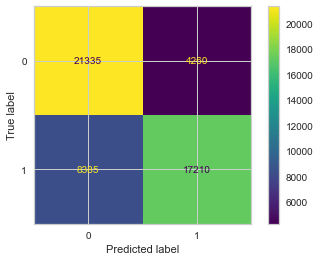

array([[-0.83272847, -1.11150824, -0.92108936,  0.44343831, -0.67676262,
        -1.13336885, -1.18770709,  1.54918228, -0.81016725, -0.74015918,
         0.58329003,  3.33612047,  2.02477027, -2.30988354, -0.66830308]])

In [29]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(pred_train['subscribed'], pred_train['prediction_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr.classes_)

disp.plot()

plt.show()

cm

tuned_lr.coef_


In [28]:
Coeff=pd.DataFrame({"Feature":X_train_selected.columns.tolist(),"Coefficients":tuned_lr.coef_[0]})

print(Coeff)

                 Feature  Coefficients
0       job_entrepreneur     -0.832728
1          job_housemaid     -1.111508
2         job_unemployed     -0.921089
3            job_retired      0.443438
4      job_self-employed     -0.676763
5       marital_divorced     -1.133369
6                default     -1.187707
7                loan_no      1.549182
8                contact     -0.810167
9              month_may     -0.740159
10             month_mar      0.583290
11              previous      3.336120
12  poutcome_nonexistent      2.024770
13      poutcome_failure     -2.309884
14           nr.employed     -0.668303
